In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/T2F/implementation/")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# !python my_train_with_use_5.py --config="configs/6.conf"

#  !python my_train_with_use_5.py --config="configs/6.conf" --start_depth=3 --ca_file="training_runs/6/saved_models/Condition_Augmentor_3.pth" --generator_file="training_runs/6/saved_models/GAN_GEN_3.pth" --discriminator_file="training_runs/6/saved_models/GAN_DIS_3.pth"

In [3]:
import datetime
import time
import torch as th
import numpy as np
import data_processing.DataLoader as dl
import argparse
import yaml
import os
import pickle
import timeit

from torch.backends import cudnn

# define the device for the training script
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)
print("-----------------------------------------------------")
print("-----------------------------------------------------")

# set torch manual seed for consistent output
th.manual_seed(3)

# Start fast training mode:
cudnn.benchmark = True



cuda
-----------------------------------------------------
-----------------------------------------------------


In [ ]:
def get_config(conf_file):
    """
    parse and load the provided configuration
    :param conf_file: configuration file
    :return: conf => parsed configuration
    """
    from easydict import EasyDict as edict

    with open(conf_file, "r") as file_descriptor:
        data = yaml.load(file_descriptor)

    # convert the data into an easyDictionary
    return edict(data)

In [5]:
    from networks.TextEncoder import Encoder
    from networks.ConditionAugmentation import ConditionAugmentor
    from networks.PRO_GAN import ConditionalProGAN

    print("configs/1.conf")
    config = get_config("configs/0.conf")
    print("Current Configuration:", config)

    # create the dataset for training
    
    dataset = dl.Face2TextDataset(
      pro_pick_file=config.processed_text_file,
      img_dir=config.images_dir,
      img_transform=dl.get_transform(config.img_dims),
      captions_len=config.captions_length
    )
    text_encoder = Encoder(
      embedding_size=config.embedding_size,
      vocab_size=dataset.vocab_size,
      hidden_size=config.hidden_size,
      num_layers=config.num_layers,
      device=device
    )
    encoder_optim = th.optim.Adam(text_encoder.parameters(),
      lr=config.learning_rate,
      betas=(config.beta_1, config.beta_2),
      eps=config.eps)


    training_number = 1
    output_depth = 4
    
    encoder_name = "training_runs/"+str(training_number)+"/saved_models/Encoder_"+str(output_depth)+".pth"
    
    # create the networks
    
    print("Loading encoder from:", encoder_name)
    text_encoder.load_state_dict(th.load(encoder_name))

    condition_augmenter = ConditionAugmentor(
        input_size=config.hidden_size,
        latent_size=config.ca_out_size,
        use_eql=config.use_eql,
        device=device
    )

    condition_augmenter_name = "training_runs/"+str(training_number)+"/saved_models/Condition_Augmentor_"+str(output_depth)+".pth"
    
    print("Loading conditioning augmenter from:", condition_augmenter_name)
    condition_augmenter.load_state_dict(th.load(condition_augmenter_name))

    c_pro_gan = ConditionalProGAN(
        embedding_size=config.hidden_size,
        depth=config.depth,
        latent_size=config.latent_size,
        compressed_latent_size=config.compressed_latent_size,
        learning_rate=config.learning_rate,
        beta_1=config.beta_1,
        beta_2=config.beta_2,
        eps=config.eps,
        drift=config.drift,
        n_critic=config.n_critic,
        use_eql=config.use_eql,
        loss=config.loss_function,
        use_ema=config.use_ema,
        ema_decay=config.ema_decay,
        device=device
    )

    generator_name = "training_runs/"+str(training_number)+"/saved_models/GAN_GEN_"+str(output_depth)+".pth"
    print("Loading generator from:", generator_name)
    c_pro_gan.gen.load_state_dict(th.load(generator_name))

    discriminator_name = "training_runs/"+str(training_number)+"/saved_models/GAN_DIS_"+str(output_depth)+".pth"
    print("Loading discriminator from:", discriminator_name)
    c_pro_gan.dis.load_state_dict(th.load(discriminator_name))

    # create the optimizer for Condition Augmenter separately
    ca_optim = th.optim.Adam(condition_augmenter.parameters(),
                             lr=config.learning_rate,
                             betas=(config.beta_1, config.beta_2),
                             eps=config.eps)


    print("Text Encoder: ")
    print(text_encoder)

    print("Conditioning Augmentor: ")
    print(condition_augmenter)

    print("Generator Config:")
    print(c_pro_gan.gen)

    print("\nDiscriminator Config:")
    print(c_pro_gan.dis)
    

    


configs/1.conf
Current Configuration: {'images_dir': '../data/LFW/lfw', 'processed_text_file': 'processed_annotations/processed_text.pkl', 'annotations_file': '../data/LFW/Face2Text/face2text_v0.1/clean.json', 'pretrained_encoder_dir': 'tf-hub_modules/text_encoder/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47', 'log_dir': 'training_runs/0/losses/', 'sample_dir': 'training_runs/0/generated_samples/', 'save_dir': 'training_runs/0/saved_models/', 'captions_length': 100, 'img_dims': [256, 256], 'download_pretrained_encoder': False, 'use_pretrained_encoder': False, 'p_proc_gpu_mem': 0.3, 'embedding_size': 128, 'hidden_size': 512, 'num_layers': 3, 'ca_out_size': 256, 'compressed_latent_size': 128, 'use_eql': True, 'use_ema': True, 'ema_decay': 0.999, 'depth': 7, 'latent_size': 512, 'learning_rate': 0.001, 'beta_1': 0, 'beta_2': 0.99, 'eps': 1e-08, 'drift': 0.001, 'n_critic': 1, 'epochs': [20, 40, 40, 40, 40, 40, 40], 'fade_in_percentage': [50, 50, 50, 50, 50, 50, 50], 'batch_sizes': [16, 16, 16, 

In [ ]:
from data_processing.TextExtractor import load_pickle
data_obj = load_pickle(config.processed_text_file)

text_data = data_obj['data']
rev_vocab = data_obj['rev_vocab']
vocab = data_obj['vocab']
images = data_obj['images']

In [ ]:
import data_processing.TextExtractor as te

descs = ["long wavy blond hair , arched eyebrows , wide smile , bony cheeks , dimple",
         "big smile, blond hair, no makeup but still a very happy face. ",
         "white male in his 4 0 's , pale complexion , huge bulging forehead probably as a result of hair loss , thin straight chocolate brown hair , dark eyes , arched eyebrows , thin pointed nose , thin upper lip , long face.",
         "long man in his 5 0 s , grimacing but does not look upset , he has bags under his eyes.",
         "An attractive woman with a lovely blonde hair style, she looks pretty seductive with her red lips. She looks like a fashion queen for her age.",
         "A woman with shoulder length brown curly hair which she wears half up and half down. She has a small forehead. Her nose is narrow but widens at the tip. She is happy and has a certain glow - she seems to be receiving a compliment or some award."
        ]

# descs = ["This is a happy face and it also looks like the face of someone who has just said something witty and has made others laugh. The smile has crinkled his face. His eyes look alert and are also laughing.",
#         "Aged gentleman with white hair, wearing spectacles",
#         "A very happy face of a young woman with a big warm smile and smiling dark eyes. She appears very well kept and groomed, with dark well-styled hair and eyebrows. She has a great set of teeth.",
#         "Young black man who has won an award, he is dressed in a top hat and tux, with corn rowed hair",
#         "White female with blue eyes and ginger hair. She has quite a long neck and an oval shaped face with very thin lips and round cheeks. She seems like she is in her mid 40s."
#         ]

initial_desc = descs

# descs = ["long wavy blond hair , arched eyebrows , wide smile , bony cheeks , dimple",
#          "An attractive woman with a lovely blonde hair style, she looks pretty seductive with her red lips. She looks like a fashion queen for her age.",
#          "A woman with shoulder length brown curly hair which she wears half up and half down. She has a small forehead. Her nose is narrow but widens at the tip. She is happy and has a certain glow - she seems to be receiving a compliment or some award."
#         ]

descs = te.basic_preprocess(descs)

descs = list(map(lambda x: x.split(), descs))

transformed_data = []  # initialize to empty list
for sentence in descs:
  transformed_sentence = []
  for word in sentence:
    numeric_code = rev_vocab[word] if word in rev_vocab else rev_vocab["<unk>"]
    transformed_sentence.append(numeric_code)
  transformed_data.append(transformed_sentence)

In [8]:
captions = transformed_data
all_captions = []

for caption in captions:
  # pad or truncate the caption length:
  if len(caption) < 100:
    while len(caption) != 100:
      caption.append(rev_vocab["<pad>"])

  elif len(caption) > 100:
    caption = caption[: 100]

  all_captions.append(caption)

# print(len(all_captions), len(all_captions[0]))
    
all_captions = th.tensor(all_captions, dtype=th.long)
all_captions = all_captions.to(device)

embeddings = text_encoder(all_captions)
c_not_hats, _, _ = condition_augmenter(embeddings)

print("c_not_hats: ", c_not_hats.shape)

c_not_hats:  torch.Size([6, 256])


In [ ]:
#Make n copies of c_not_hats

num_images_per_desc = 8
c_not_hats = c_not_hats.repeat(1,num_images_per_desc).view(-1,c_not_hats[0].shape[0])

In [10]:
c_not_hats.shape[0]

48

In [11]:
noise = th.randn(c_not_hats.shape[0], c_pro_gan.latent_size - c_not_hats.shape[-1]).to(device)
gan_input = th.cat((c_not_hats, noise), dim=-1)
    
samples=c_pro_gan.gen(gan_input,4,1)
samples

tensor([[[[-0.2276, -0.1079, -0.1503,  ...,  0.5185, -0.2308, -1.3819],
          [-0.5944, -0.4230, -0.4425,  ...,  0.3460, -0.7233, -1.7836],
          [-0.5245, -0.5239, -0.4748,  ...,  0.3012, -0.8735, -1.8272],
          ...,
          [-0.3259, -0.2541, -0.1988,  ..., -0.9776, -0.8114, -0.4377],
          [-0.4734, -0.5736, -0.1927,  ..., -0.9867, -0.9643, -0.7383],
          [-0.9201, -1.0028, -0.3221,  ..., -0.9117, -0.8189, -1.0669]],

         [[-0.5066, -0.2752, -0.2316,  ...,  0.3393, -0.6503, -1.4520],
          [-0.4897, -0.4501, -0.3843,  ...,  0.3961, -0.5566, -1.7102],
          [-0.4501, -0.4764, -0.4632,  ...,  0.2934, -0.7123, -1.9863],
          ...,
          [-0.4009, -0.2776, -0.1896,  ..., -0.9786, -0.8891, -0.7021],
          [-0.3525, -0.6181, -0.5185,  ..., -1.0268, -0.9972, -0.8819],
          [-0.7447, -0.9449, -0.8464,  ..., -1.1492, -1.1001, -0.9940]],

         [[-0.6687, -0.3749, -0.4246,  ...,  0.0536, -0.7880, -1.6886],
          [-0.6508, -0.5304, -

In [12]:
samples1 = samples
samples1.shape

torch.Size([48, 3, 64, 64])

In [13]:
samples = th.clamp((samples / 2) + 0.5, min=0, max=1)
samples.shape

torch.Size([48, 3, 64, 64])

In [14]:
samples

tensor([[[[3.8619e-01, 4.4605e-01, 4.2485e-01,  ..., 7.5924e-01,
           3.8459e-01, 0.0000e+00],
          [2.0281e-01, 2.8852e-01, 2.7873e-01,  ..., 6.7300e-01,
           1.3834e-01, 0.0000e+00],
          [2.3777e-01, 2.3804e-01, 2.6260e-01,  ..., 6.5062e-01,
           6.3228e-02, 0.0000e+00],
          ...,
          [3.3703e-01, 3.7294e-01, 4.0058e-01,  ..., 1.1187e-02,
           9.4302e-02, 2.8114e-01],
          [2.6328e-01, 2.1322e-01, 4.0365e-01,  ..., 6.6325e-03,
           1.7863e-02, 1.3087e-01],
          [3.9961e-02, 0.0000e+00, 3.3893e-01,  ..., 4.4158e-02,
           9.0540e-02, 0.0000e+00]],

         [[2.4671e-01, 3.6239e-01, 3.8421e-01,  ..., 6.6963e-01,
           1.7485e-01, 0.0000e+00],
          [2.5513e-01, 2.7496e-01, 3.0784e-01,  ..., 6.9803e-01,
           2.2169e-01, 0.0000e+00],
          [2.7494e-01, 2.6182e-01, 2.6842e-01,  ..., 6.4668e-01,
           1.4385e-01, 0.0000e+00],
          ...,
          [2.9956e-01, 3.6120e-01, 4.0519e-01,  ..., 1.0685

In [ ]:
import ipywidgets
import matplotlib.pyplot as plt
from torchvision.utils import save_image,make_grid
from torch.nn.functional import interpolate
from PIL import Image
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [16]:
samples = interpolate(samples, scale_factor=4)
samples.shape

torch.Size([48, 3, 256, 256])

In [ ]:
# save_image(samples, os.path.join(config.sample_dir, "_image_4_17" + ".png"), nrow=int(np.sqrt(len(samples))))

In [18]:
samples.shape

torch.Size([48, 3, 256, 256])

In [ ]:
#INCEPTION SCORES

from torchvision.models.inception import inception_v3
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import numpy as np
from scipy.stats import entropy
import math


def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)
    
    assert batch_size > 0
    assert N >= batch_size

    # Set up dtype
    if cuda:
        dtype = th.cuda.FloatTensor
    else:
        if th.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = th.FloatTensor

    # Set up dataloader
    dataloader = th.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))
    print(preds)
    
    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []
    
    #To check class in which there in max probability
    print(np.argmax(preds, axis=1))
  
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        print("Part shape:", part.shape)
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [20]:
inception_score(samples)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[898 457 683 678 680 400 457 678 602 901 680 715 610 680 680 680 160 680
 194 680 451 451 101 163 982 585 731 435 739 837 601 451 416 457 406 862
 577 641 851 457 101 793 691 101 837 392 715 851]
Part shape: (48, 1000)


(3.583257002439329, 0.0)

In [ ]:
# %matplotlib inline
def show(img):
    npimg = img.data.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis("off")
    plt.show()

long wavy blond hair , arched eyebrows , wide smile , bony cheeks , dimple
big smile, blond hair, no makeup but still a very happy face. 
white male in his 4 0 's , pale complexion , huge bulging forehead probably as a result of hair loss , thin straight chocolate brown hair , dark eyes , arched eyebrows , thin pointed nose , thin upper lip , long face.
long man in his 5 0 s , grimacing but does not look upset , he has bags under his eyes.
An attractive woman with a lovely blonde hair style, she looks pretty seductive with her red lips. She looks like a fashion queen for her age.
A woman with shoulder length brown curly hair which she wears half up and half down. She has a small forehead. Her nose is narrow but widens at the tip. She is happy and has a certain glow - she seems to be receiving a compliment or some award.


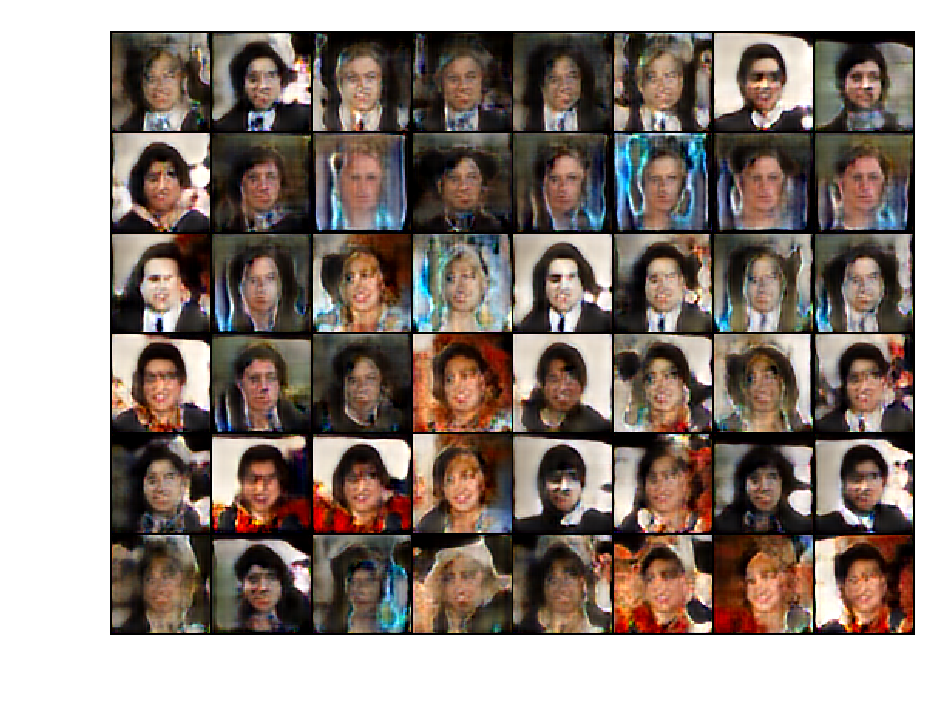

In [22]:
for desc in initial_desc:
  print(desc)

show(make_grid(samples, nrow=num_images_per_desc, padding=5))


HTML(value='long wavy blond hair , arched eyebrows , wide smile , bony cheeks , dimple', layout=Layout(width='…

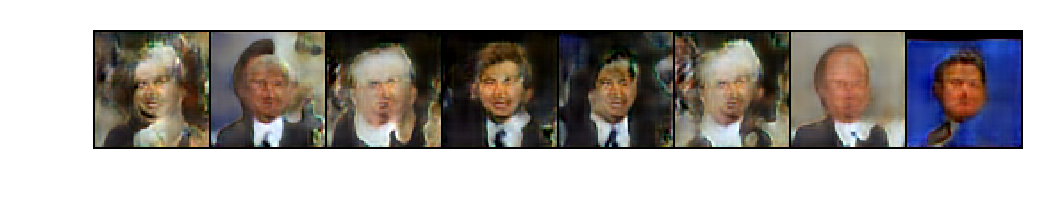

HTML(value='big smile, blond hair, no makeup but still a very happy face. ', layout=Layout(width='500px'))

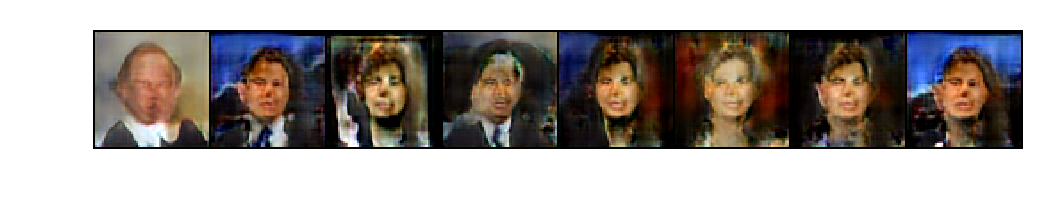

HTML(value="white male in his 4 0 's , pale complexion , huge bulging forehead probably as a result of hair lo…

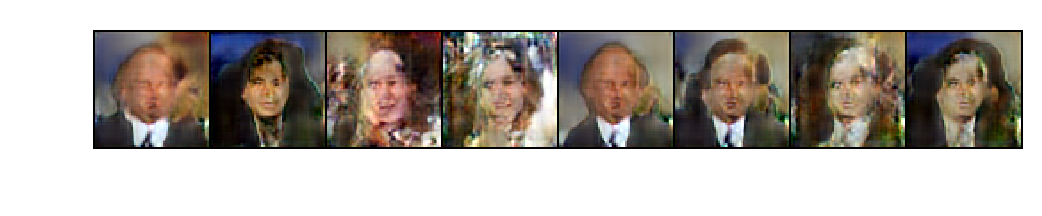

HTML(value='long man in his 5 0 s , grimacing but does not look upset , he has bags under his eyes.', layout=L…

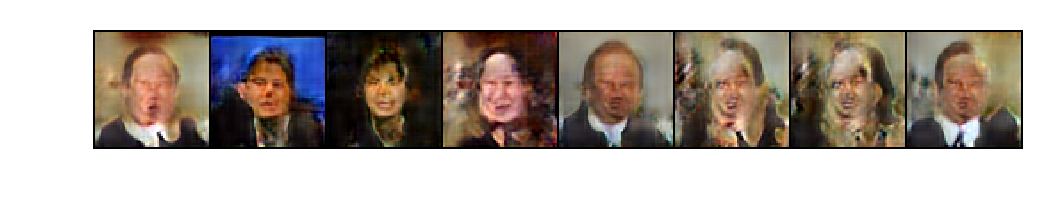

HTML(value='An attractive woman with a lovely blonde hair style, she looks pretty seductive with her red lips.…

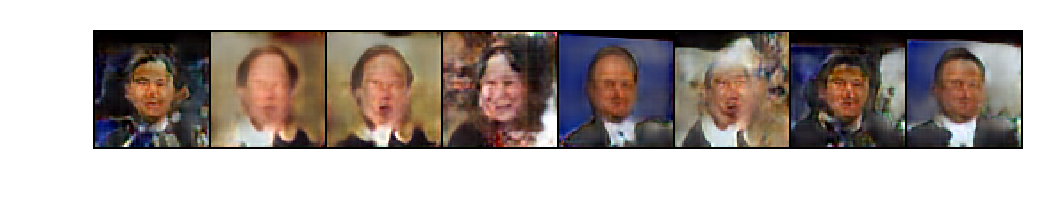

HTML(value='A woman with shoulder length brown curly hair which she wears half up and half down. She has a sma…

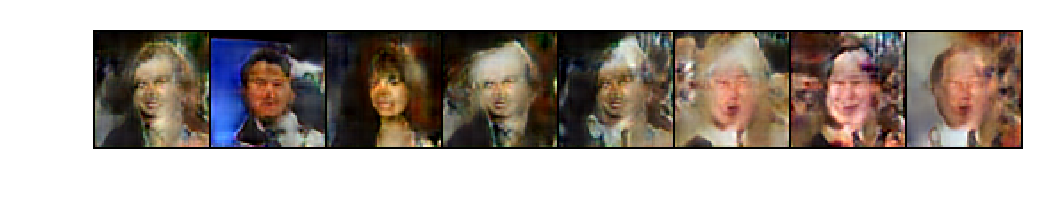

In [22]:
for i in range(len(initial_desc)):
#   print(initial_desc[i])
  
  description = ipywidgets.widgets.HTML(value=initial_desc[i], layout=ipywidgets.Layout(width='500px'))
  display(description)
  
  show(make_grid(samples[i*num_images_per_desc:(i+1)*num_images_per_desc], nrow=num_images_per_desc, padding=5))

  

In [ ]:
config.log_dir

'training_runs/0/losses/'

In [ ]:
# Plot loss graphs
loss_figure = os.path.join('training_runs/8/losses/', "loss_" + str(0) + ".png")                   
log_file = os.path.join('training_runs/8/losses/', "loss_" + str(0) + ".log")   

with open(log_file) as log:
  lines = log.readlines()
  
gen_loss = np.array([])
dis_loss = np.array([])
# kl_loss = np.array([])
for line in lines:
  loss_values = line.split()
  gen_loss = np.append(gen_loss,loss_values[1])
  dis_loss = np.append(dis_loss,loss_values[0])
#   kl_loss = np.append(kl_loss,loss_values[2])

gen_loss = gen_loss[:100]
dis_loss = dis_loss[:100]
# kl_loss = kl_loss[:-2]

# N = np.arange(0, len(gen_loss))

plt.figure(figsize=(17,7)).suptitle("Training Loss Values for 4x4")



    
# plt.plot(N, gen_loss.astype(float), color='g', label="GENERATOR LOSS")
# plt.plot(N, dis_loss.astype(float), color='r', label="DISCRIMINATOR LOSS")
# plt.plot(N, kl_loss.astype(float), color='b', label="KL LOSS")

plt.legend(loc='upper left')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plts = [] 
plts.append(plt.plot(gen_loss.astype(float), color='g')[0])
plts.append(plt.plot(dis_loss.astype(float), color='b')[0])

plt.legend(plts, ("GENERATOR","DISCRIMINATOR"), loc="upper right", fontsize=16)
    
  
plt.savefig(loss_figure)
plt.show()

# log.write(str(dis_loss) + "\t" + str(gen_loss) + "\t" + str(kl_loss.item()) + "\n")


In [ ]:
(samples1/2 ) + 0.5

In [ ]:
samples1

In [ ]:
# LOAD IMAGES FROM DATASET

temp_data = dl.get_data_loader(dataset, config.batch_sizes[0], num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()

In [ ]:
fixed_real_images

In [ ]:
real_imgs = th.clamp((fixed_real_images/2) + 0.5, min=0, max=1)

show(make_grid(real_imgs[0:8], nrow=num_images_per_desc, padding=5))

In [ ]:
samples_plotting = th.clamp((samples1/2) + 0.5, min=0, max=1)
samples_plotting = interpolate(samples_plotting, scale_factor=4)
show(make_grid(samples_plotting[0:8], nrow=num_images_per_desc, padding=5))

In [ ]:
samples_plotting.shape

## TAKING SENTENCE INPUT AND PLOTTING THE IMAGE SIMULTANEOUSLY


In [51]:
input_desc = input()

old man with wrinkled face, grey hair and no beard, seems to have a happy face.


c_not_hats:  torch.Size([1, 256])


HTML(value='old man with wrinkled face, grey hair and no beard, seems to have a happy face.', layout=Layout(wi…

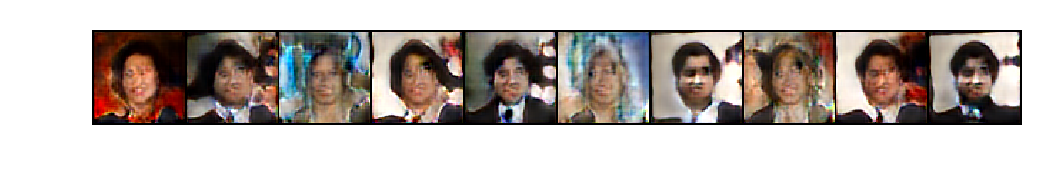

In [55]:
desc = []
desc.append(input_desc)
descs = te.basic_preprocess(desc)

descs = list(map(lambda x: x.split(), descs))

transformed_data = []  # initialize to empty list
for sentence in descs:
  transformed_sentence = []
  for word in sentence:
    numeric_code = rev_vocab[word] if word in rev_vocab else rev_vocab["<unk>"]
    transformed_sentence.append(numeric_code)
  transformed_data.append(transformed_sentence)
  
captions = transformed_data
all_captions = []

for caption in captions:
  # pad or truncate the caption length:
  if len(caption) < 100:
    while len(caption) != 100:
      caption.append(rev_vocab["<pad>"])

  elif len(caption) > 100:
    caption = caption[: 100]

  all_captions.append(caption)

# print(len(all_captions), len(all_captions[0]))
    
all_captions = th.tensor(all_captions, dtype=th.long)
all_captions = all_captions.to(device)

embeddings = text_encoder(all_captions)
c_not_hats, _, _ = condition_augmenter(embeddings)

print("c_not_hats: ", c_not_hats.shape)

num_images_per_desc = 10
c_not_hats = c_not_hats.repeat(1,num_images_per_desc).view(-1,c_not_hats[0].shape[0])

noise = th.randn(c_not_hats.shape[0], c_pro_gan.latent_size - c_not_hats.shape[-1]).to(device)
gan_input = th.cat((c_not_hats, noise), dim=-1)
    
samples=c_pro_gan.gen(gan_input,4,1)

samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

samples = interpolate(samples, scale_factor=4)

description = ipywidgets.widgets.HTML(value=desc[0], layout=ipywidgets.Layout(width='500px'))
display(description)

show(make_grid(samples, nrow=num_images_per_desc, padding=5))

In [ ]:
samples[8].shape
samples[2] = samples[0] = samples[8]


In [ ]:
copy_1 = sample1
copy_2 = sample2
copy_1.shape

torch.Size([512])

In [ ]:
copy_1 = copy_1[None,:]
copy_2 = copy_2[None,:]

torch.Size([10, 512])


HTML(value='A male with a perplexed look wearing short fuzzy hair and a tan suit. A fat, large nose and a thin…

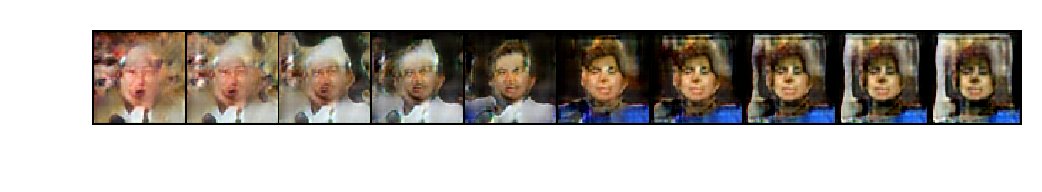

HTML(value='Black hair, pointed nose and expressionless face.', layout=Layout(width='500px'))

In [ ]:

t_array = np.array([0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1])

def interpolation(first, second):
  
  temp = first
 
  for i in range(len(t_array)):
    cur = (1 - t_array[i])*first + t_array[i]*second
      
    temp = th.cat((temp,cur), dim=0) 
  
  print(temp.shape)
  
  samples=c_pro_gan.gen(temp,4,1)

  samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

  samples = interpolate(samples, scale_factor=4)

  description = ipywidgets.widgets.HTML(value="A male with a perplexed look wearing short fuzzy hair and a tan suit. A fat, large nose and a thin moustache give him a believable personality.", layout=ipywidgets.Layout(width='500px'))
  display(description)

  show(make_grid(samples, nrow=num_images_per_desc, padding=5))
  
  description = ipywidgets.widgets.HTML(value="Black hair, pointed nose and expressionless face.", layout=ipywidgets.Layout(width='500px'))
  display(description)
  
interpolation(copy_1, copy_2)
# print(sample1.shape)
# print(2*sample1)

In [ ]:
# LOADING FEATURE DIRECTIONS
import glob


""" load learnt feature axis directions """

path_feature_direction = './pg_gan_celeba_feature_direction_40'

pathfile_feature_direction = glob.glob(os.path.join(path_feature_direction, 'feature_direction_*.pkl'))[-1]

with open(pathfile_feature_direction, 'rb') as f:
    feature_direction_name = pickle.load(f)
    
feature_direction = feature_direction_name['direction']
feature_name = feature_direction_name['name']
num_feature = feature_direction.shape[1]

In [ ]:
gan_input[8].shape

torch.Size([512])

In [ ]:
for i in range(len(feature_name)):
  print(i, "  ", feature_name[i])

0    5_o_Clock_Shadow
1    Arched_Eyebrows
2    Attractive
3    Bags_Under_Eyes
4    Bald
5    Bangs
6    Big_Lips
7    Big_Nose
8    Black_Hair
9    Blond_Hair
10    Blurry
11    Brown_Hair
12    Bushy_Eyebrows
13    Chubby
14    Double_Chin
15    Eyeglasses
16    Goatee
17    Gray_Hair
18    Heavy_Makeup
19    High_Cheekbones
20    Male
21    Mouth_Slightly_Open
22    Mustache
23    Narrow_Eyes
24    No_Beard
25    Oval_Face
26    Pale_Skin
27    Pointy_Nose
28    Receding_Hairline
29    Rosy_Cheeks
30    Sideburns
31    Smiling
32    Straight_Hair
33    Wavy_Hair
34    Wearing_Earrings
35    Wearing_Hat
36    Wearing_Lipstick
37    Wearing_Necklace
38    Wearing_Necktie
39    Young


In [ ]:
def plot_feature_change(input_vector, feature_idx):
  feature_direction_sel = torch.from_numpy(feature_direction[:,feature_idx]).float().to(device)

  
  gan_latent_input_vector = input_vector

  all_inputs = gan_latent_input_vector
  all_inputs.unsqueeze_(0)


  for i in range(0,18,2):
    temp = feature_direction_sel * i
    temp.unsqueeze_(0)
    new_input = gan_latent_input_vector + temp

    all_inputs = th.cat((all_inputs,new_input), dim=0)
  
  new_samples = c_pro_gan.gen(all_inputs,4,1)

  new_samples = th.clamp((new_samples / 2) + 0.5, min=0, max=1)

  new_samples = interpolate(new_samples, scale_factor=4)

  description = ipywidgets.widgets.HTML(value=feature_name[feature_idx], layout=ipywidgets.Layout(width='500px'))
  display(description)

  show(make_grid(new_samples, nrow=num_images_per_desc, padding=5))

# description = ipywidgets.widgets.HTML(value=feature_name[8], layout=ipywidgets.Layout(width='500px'))
# display(description)

for i in range(len(feature_name)):
  plot_feature_change(gan_input[2], i)

  
  
# 8 -- black hair
# 20 -- male
# 21 -- mouth open
# 25 - oval face
# 26 - pale skin
# 31 - smiling
# 39 - young

# feature_idx = 39
# print(feature_name[feature_idx])
# feature_direction = torch.from_numpy(feature_direction[:,feature_idx]).float().to(device)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
gan_latent_input_vector = gan_input[8]

all_inputs = gan_latent_input_vector
all_inputs.unsqueeze_(0)


for i in range(0,18,2):
  temp = feature_direction * i
  temp.unsqueeze_(0)
  new_input = gan_latent_input_vector + temp
  
  all_inputs = th.cat((all_inputs,new_input), dim=0)

In [ ]:
gan_input[8].shape

torch.Size([512])

HTML(value='A young women smiling and cheerful face', layout=Layout(width='500px'))

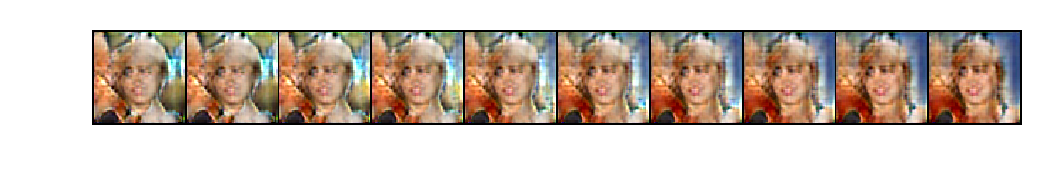

torch.Size([10, 3, 256, 256])


In [ ]:
new_samples = c_pro_gan.gen(all_inputs,4,1)

new_samples = th.clamp((new_samples / 2) + 0.5, min=0, max=1)

new_samples = interpolate(new_samples, scale_factor=4)

description = ipywidgets.widgets.HTML(value=desc[0], layout=ipywidgets.Layout(width='500px'))
display(description)

show(make_grid(new_samples, nrow=num_images_per_desc, padding=5))

print(new_samples.shape)

In [ ]:
description = ipywidgets.widgets.HTML(value="White person with bald head and ugly face.", layout=ipywidgets.Layout(width='500px'))
display(description)

HTML(value='A young women smiling and cheerful face', layout=Layout(width='500px'))

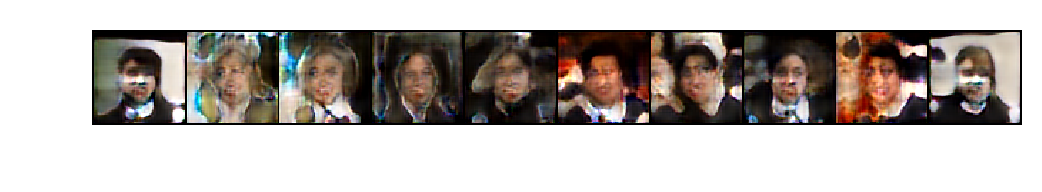

In [ ]:
noise = th.randn(10, 512).to(device)
gan_input = noise
    
samples=c_pro_gan.gen(noise,4,1)

samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

samples = interpolate(samples, scale_factor=4)

description = ipywidgets.widgets.HTML(value=desc[0], layout=ipywidgets.Layout(width='500px'))
display(description)

show(make_grid(samples, nrow=num_images_per_desc, padding=5))